# CS 136 day05 Lab: Dirichlet distribution and Dirichlet-Categorical models


## Outline

* **Part 1: Dirichlet Distribution visualization**
* * Examine several ways to visualize samples from a Dirichlet.
* * Exercises 1a-1e: Write code to draw samples from several possible Dirichlets.
* * Exercises 1f-1g: Create and interpret pairplot and triangle plot visuals of Dirichlet distributions

* **Part 2: Dirichlet-Categorical Posteriors**
* * Exercise 2a: Write function to determine the posterior parameters after seeing many observations
* * Exercise 2b: Show the posterior after seeing 1, 10, 100, 1000, 10000 samples, with a uniform prior
* * Exercise 2d: Show the posterior after seeing 1, 10, 100, 1000, 10000 samples, with a different (misinformed) prior

## Takeaways


* To draw samples:
* * [`scipy.stats.dirichlet(hyperparameters).rvs(size=(nrows,ncols), random_state=SEED)`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.dirichlet.html)
* * OR [`np.random.dirichlet(hyperparameters)`](https://numpy.org/doc/stable/reference/random/generated/numpy.random.dirichlet.html)
* To evaluate the PDF:
* * Evaluate pdf with `scipy.stats.<distribution>(hyperparameters).pdf(values)` (can use the `logpdf` instead of `pdf`)

* Visualizing V-ary dirichlets (with 3 categories) can be done with a triangle view (since the actual space of allowed parameters has 2 effective dimensions on one plane)

In [ ]:
import numpy as np
import pandas as pd
import scipy.stats

In [ ]:
np.set_printoptions(precision=3, suppress=False)

In [ ]:
pd.options.display.float_format = '{:,.3g}'.format  # show 4 digits of precision

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.25)

# Part 1: Dirichlet Distribution, Visualized

## Dirichlet distribution background

Suppose we have $V$ possible categories, known in advance.

We want a distribution over possible *V-dimensional probability vectors*

We can think of this as a "distribution over distributions".

#### Random Variable: Probability vector $\mu \in \Delta^{V}$

This is a vector of *non-negative entries that sum to one*:

$$
\mathbf{\mu} = [\mu_1, \mu_2, \ldots \mu_V ]
$$

where $\mu_v \geq 0$ and $\sum_{v=1}^V \mu_v = 1$

#### Parameters: Pseudocount vector $\alpha \in \mathbb{R}_+^V$

This is a vector of all positive numbers:

$$
\mathbf{\alpha} = [\alpha_1, \alpha_2, \ldots \alpha_V ]
$$

Where $\alpha_1 > 0$, $\alpha_2 > 0$, etc.


#### Formal definition of PDF: 



$$
\text{DirPDF}\left( [\mu_1 \ldots \mu_V] \mid [\alpha_1 \ldots \alpha_V] \right) 
    = c(\alpha) \cdot \prod_{v=1}^V \mu_v^{\alpha_v-1}
$$

with normalizing "constant" (a term constant wrt $\mu$):

$$
c(\alpha) = \frac
    {\Gamma( \sum_{v=1}^V \alpha_v )}
    {\prod_{v=1}^V \Gamma(\alpha_v)}
$$

#### Standard Numerical implementations

You can use the built-in functions from SciPy to sample from this distribution:

* To draw samples:
* * [`scipy.stats.dirichlet(hyperparameters).rvs(size=(nrows,ncols), random_state=SEED)`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.dirichlet.html)
* * OR [`np.random.dirichlet(hyperparameters)`](https://numpy.org/doc/stable/reference/random/generated/numpy.random.dirichlet.html)

See <https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.dirichlet.html>


Set our random state so things are reproducible.

In [ ]:
prng = np.random.RandomState(0)

## Drawing samples with V=2

The code below prints out vectors $\mu$ sampled from a Dirichlet with particular $\alpha$

#### First try with symmetric all-ones parameter $\alpha = [1, 1]$

In [ ]:
V = 2

ones_alpha_V = np.ones(V)

In [ ]:
prng.dirichlet(ones_alpha_V)

array([0.388, 0.612])

In [ ]:
prng.dirichlet(ones_alpha_V)

array([0.54, 0.46])

In [ ]:
prng.dirichlet(ones_alpha_V)

array([0.347, 0.653])

#### Now try with symmetric parameter $\alpha = [0.1, 0.1]$

In [ ]:
point1_alpha_V = 0.1 * np.ones(V)

In [ ]:
prng.dirichlet(point1_alpha_V)

array([2.542e-04, 9.997e-01])

In [ ]:
prng.dirichlet(point1_alpha_V)

array([0.965, 0.035])

In [ ]:
prng.dirichlet(point1_alpha_V)

array([1.000e+00, 3.489e-06])

## Discussion 1a: What do you notice when you compare the $\alpha = [1, 1]$ to $\alpha = [0.1, 0.1]$? 

> TODO discuss

## Discussion 1b: What do you expect to happen for symmetric $\alpha = [0.001, 0.001]$? What about symmetric $\alpha = [33, 33]$?

TODO discuss

## Exercise 1c: Write code to draw 3 samples from $\alpha = [0.001, 0.001]$ with V=2

> TODO write code (hint: see lines above)

## Exercise 1d: Write code to draw 3 samples from $\alpha = [33, 33, 33]$ with V=3

> TODO write code (hint: see lines above for how to call .dirichlet() )

## Exercise 1e: Write code to draw 3 samples from $\alpha = [70, 20, 10]$ with V=3

> TODO write code (hint: see lines above)

# Setup Visualization: Plotting V=3 samples on the 'triangle'

This code below just defines a function to help us visualize a provided array of samples of vector mu. 

Don't worry too much about understanding the details, so feel free to skip ahead.

In [ ]:
def show_samples_on_V3_triangle(mu_S3=None, ax_handle=None, transparency=1.0):
    ''' Show samples from a Dirichlet on the triangle view of the V=3 simplex
    
    Create a triangle where each corner represents one extreme one-hot mu value
    Then plot each sampled mu vector (in V=3 dim space) as a point on this triangle
    
    Args
    ----
    mu_S3 : None or 2D array, shape (n_samples, n_categories) = (S, V)
        Provide many samples of 3-dimensional probability vectors
        Each row of this array should sum to one.
        Each sample vector will be visualized as a point on the triangle.
        If None, just plot the triangle with no samples.
    ax_handle : None or matplotlib axis handle
        If an axis handle is provided, will draw triangle in this handle
        If None, will create a new figure
    transparency : float, between 0.0 and 1.0
        Specifies the transparency of the samples.
        When number of samples is small, defaults to 1.0 so each sample easy to see.
        When number of samples is large, useful to set small (like 0.05) so density is visible.
    
    References
    ----------
    Many thanks to code here that inspired this
    http://y-okamoto-psy1949.la.coocan.jp/Python/en1/Dirichlet/
    '''
    # Create new figure if needed
    if ax_handle is None:
        plt.figure(figsize = (5, 5))
        ax_handle = plt.gca()
    else:
        plt.sca(ax_handle)

    # Create 3 vertices of an equilateral triangle
    P1_12 = np.asarray([0.0, (3.0**0.5) - 1.0]).reshape((1,2))
    P2_12 = np.array([-1.0, -1.0]).reshape((1,2))
    P3_12 = np.array([1.0, -1.0]).reshape((1,2))
    corners_32 = np.vstack([P1_12, P2_12, P3_12])
    
    # Draw the triangle
    # be sure to complete outline by going back to first point
    corners_42 = np.vstack([corners_32, P1_12])
    ax_handle.plot(corners_42[:,0], corners_42[:,1])
    
    # Label each vertex of the triangle
    B = 0.2
    ax_handle.text(P1_12[0,0] + B/2, P1_12[0,1] - B/3,
                   '$\mu = [1, 0, 0]$', fontsize = 12)
    ax_handle.text(P2_12[0,0], P2_12[0,1] - B/2,
                   '$\mu = [0, 1, 0]$', fontsize = 12)
    ax_handle.text(P3_12[0,0] - 3*B, P3_12[0,1] - B/2,
                   '$\mu = [0, 0, 1]$', fontsize = 12)

    # Make plot pretty
    ax_handle.set_yticks([]);
    ax_handle.set_xticks([]);
    sns.despine(top=True, right=True, left=True, bottom=True);
    ax_handle.set_aspect('equal');

    # Show provided sample points as points within the triangle
    if mu_S3 is not None:
        assert mu_S3.ndim == 2
        S, V = mu_S3.shape
        assert V == 3

        points_S2 = np.dot(mu_S3, corners_32)
        ax_handle.plot(points_S2[:,0], points_S2[:,1],
                       '.', color='b', linewidth=0, alpha=transparency)

# Show empty triangle visual

The triangle's corners represent the 3 "extreme" possible values of $\mu$

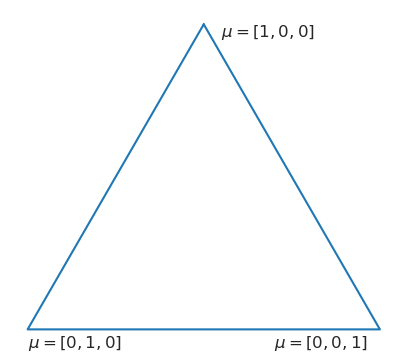

In [ ]:
show_samples_on_V3_triangle()

# Show an interior value of mu

We show a particular $\mu$ vector on the triangle plot, marked by the blue dot

Plotting mu_1V
-------------
[[0.05 0.15 0.8 ]]


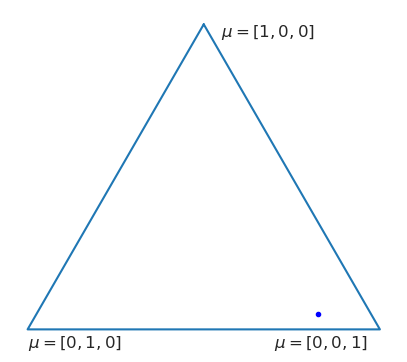

In [ ]:
mu_1V = np.asarray([[0.05, 0.15, 0.8]])

print("Plotting mu_1V")
print("-------------")
print(mu_1V)

show_samples_on_V3_triangle(mu_1V)

## Discussion 1f: Does the location of the plotted mu as a dot within the triangle make sense?

> TODO discuss

## Example 1(i): Generate Samples from Dirichlet(alpha = [70, 20, 10])

Let's generate many samples from a specific Dirichlet distribution, and practice visualizing it

In [ ]:
V = 3
alpha_V = np.asarray([70, 20, 10])

In [ ]:
# First, make a 2D array that is (n_samples, n_categories) = (S, V)
S = 10000
mu_SV = np.zeros((S, V))

# Fill in this array with samples from a dirichlet over V categories
for s in range(S):
    mu_SV[s] = prng.dirichlet(alpha_V)
    
# Convert to a pandas data frame (easy to use with seaborn visualization library)
mu_df = pd.DataFrame(mu_SV, columns=['$\mu_1$', '$\mu_2$', '$\mu_3$'])

# Print out the first 5 rows
mu_df.head()

,$\mu_1$,$\mu_2$,$\mu_3$
0,0.669,0.193,0.138
1,0.754,0.115,0.131
2,0.756,0.116,0.128
3,0.8,0.155,0.0457
4,0.714,0.226,0.06


## Pair plot for samples from Dirichlet( alpha = [70, 20, 10] )

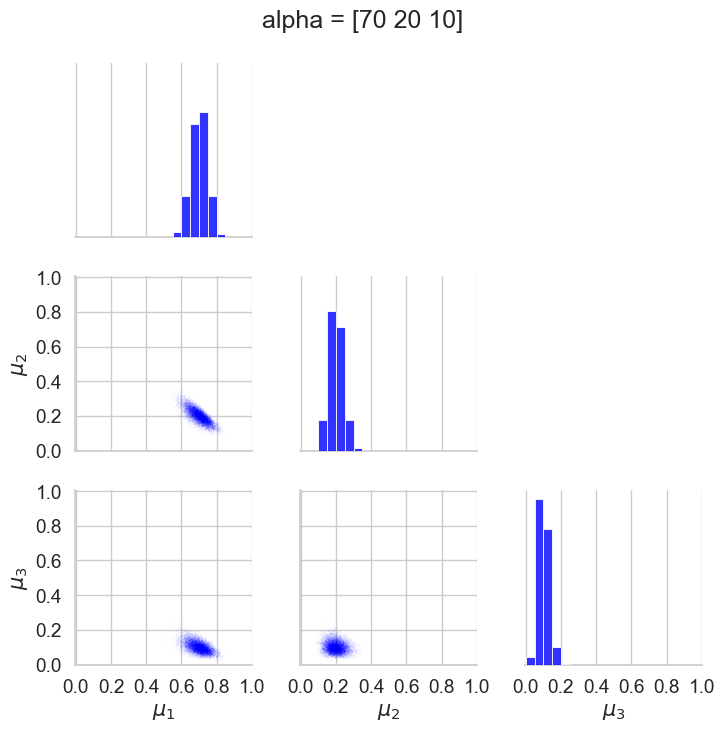

In [ ]:
fig_handle = sns.pairplot(
    mu_df,
    aspect=1.0,
    corner=True, # only lower triangle
    diag_kws={"color": 'b', "alpha": 0.8, "bins":np.linspace(0, 1, 21)},
    plot_kws={"color": 'b', "alpha": 0.05, "s": 3, 'marker': '.', 'edgecolor':'none'})
# ^- alpha here means transparency for the 'alpha' channel of the RGB-A scheme

B = 0.003
fig_handle.set(
    xlim=(-B, 1+B), xticks=[0.0, 0.2, 0.4, 0.6, 0.8, 1.0],
    ylim = (-B, 1+B), yticks=[0.0, 0.2, 0.4, 0.6, 0.8, 1.0]);
plt.suptitle("alpha = %s" % str(alpha_V));
plt.tight_layout(); # improve spread and visibility of subplots


## Triangle plot for samples from Dir( alpha = [70, 20, 10] )

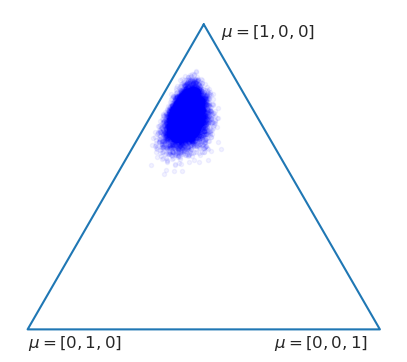

In [ ]:
show_samples_on_V3_triangle(mu_df.values, transparency=0.05)

## Example 1(ii): Generate Samples alpha = [0.9, 0.5, 0.1]

In [ ]:
V = 3
alpha_V = np.asarray([0.9, 0.5, 0.1])

In [ ]:
# First, make a 2D array that is (n_samples, n_categories) = (S, V)
S = 10000
mu_SV = np.zeros((S, V))

# Fill in this array with samples from a dirichlet over V categories
for s in range(S):
    mu_SV[s] = prng.dirichlet(alpha_V)
    
mu_df = pd.DataFrame(mu_SV, columns=['$\mu_1$', '$\mu_2$', '$\mu_3$'])
mu_df.head()

,$\mu_1$,$\mu_2$,$\mu_3$
0,0.918,0.0816,0.00018
1,0.998,0.00196,1.78e-07
2,0.326,0.666,0.00768
3,0.906,0.0938,1.1e-17
4,0.931,0.0693,5.68e-05


## Pair plot visual with alpha = [0.9, 0.5, 0.1]

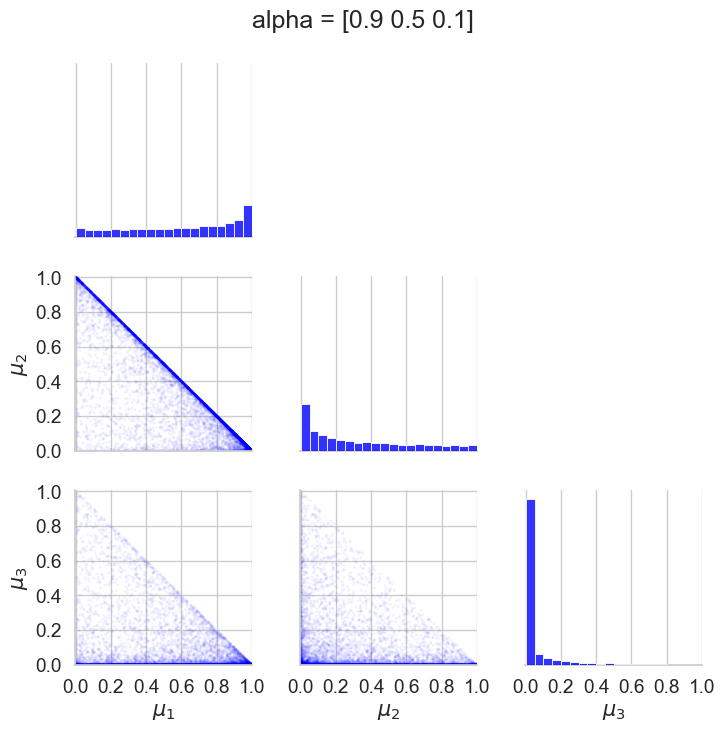

In [ ]:
fig_handle = sns.pairplot(
    mu_df,
    aspect=1.0,
    corner=True, # only lower triangle
    diag_kws={"color": 'b', "alpha": 0.8, "bins":np.linspace(0, 1, 21)},
    plot_kws={"color": 'b', "alpha": 0.05, "size": 3, 'marker': '.', 'edgecolor':'none'})
# ^- alpha here means transparency for the 'alpha' channel of the RGB-A scheme

B = 0.003
fig_handle.set(
    xlim=(-B, 1+B), xticks=[0.0, 0.2, 0.4, 0.6, 0.8, 1.0],
    ylim = (-B, 1+B), yticks=[0.0, 0.2, 0.4, 0.6, 0.8, 1.0]);
plt.suptitle("alpha = %s" % str(alpha_V));
plt.tight_layout(); # improve spread and visibility of subplots


# Triangle visualization of alpha = [0.9, 0.5, 0.1]

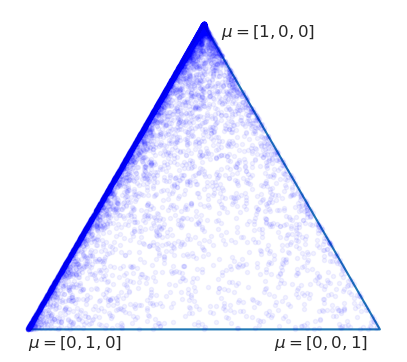

In [ ]:
show_samples_on_V3_triangle(mu_df.values, transparency=0.05)

## Exercise 1g: Create visuals for alpha = [333, 33, 3]

In [ ]:
# TODO write code to sample mu

In [ ]:
# TODO write code to make pairplot

In [ ]:
# TODO write code to make triangle plot

# Part 2: Posterior visualization in the Dir-Cat model

We'll assume the Dir-Cat model discussed in class

Our random variables are:

\begin{align}
\text{probability vector} \quad & \mu \in \Delta^V
\\
\text{observed category indicators} \quad & x_n \in \{1, \ldots V\}
\end{align}


\begin{align}
p(\mu) &= \text{Dir}( \mu | \alpha)
\\
p(x_1, \ldots x_N | \mu) &= \prod_{n=1}^N \text{CatPMF}( x_n | \mu)
\end{align}

We are interested in the posterior:

$$
p( \mu | x_1, \ldots x_N)
$$

## Exercise 2a: Calculating posterior parameters

Using the formulas discussed in the textbook / video lecture, complete the function below to determine the parameters of the Dirichlet posterior distribution after seeing N one-hot encoded outcomes in array `x_NV`


Resource: page 8-9 of the day04 notes: https://www.cs.tufts.edu/comp/136/2021s/notes/day04.pdf#page=08

In [ ]:
def calc_dirichlet_posterior_parameters(x_NV, alpha_V):
    ''' Compute Dirichlet posterior parameters
    
    Args
    ----
    x_NV : 2D array, shape (n_examples, n_categories) = (N, V)
        Each row is a one-hot vector of size V indicating a single categorical outcome
    alpha_V : 1D array, shape (n_categories,) = (V,)
        Prior parameter, "pseudocounts" for each category
        All entries must be positive
    
    Returns
    -------
    alphahat_V : 1D array, shape (n_categories,) = (V,)
        Prior parameter, "pseudocounts" for each category
        All entries must be positive
    '''
    alphahat_V = alpha_V # TODO FIXME <<<<<<<<<<<<<<<<<<<
    return alphahat_V

## Draw 'fake' categorical data X  from model given parameter mu

In [ ]:
# Define a random generator object, with specific seed for reproducibility
prng = np.random.RandomState(101)

In [ ]:
# Pick a "true" probability vector: 30%, 50%, 20%
true_mu_V = np.asarray([0.3, 0.5, 0.2])

print("true_mu_V")
print("---------")
print(true_mu_V)

true_mu_V
---------
[0.3 0.5 0.2]


In [ ]:
# Settings
N = 10000                 # num data examples to observe

# Sample N examples from Multinomial with 1 trial (aka Categorical) given mu
x_NV = scipy.stats.multinomial(1, true_mu_V).rvs(size=N, random_state=prng)


print("x_NV with shape " + str(x_NV.shape))
print("---------")
print(x_NV[:5])
print("...")

x_NV with shape (10000, 3)
---------
[[0 1 0]
 [0 1 0]
 [0 0 1]
 [0 0 1]
 [1 0 0]]
...


## Exercise 2b: Visualizing Posterior given a *uniform* prior

Complete the code below, to visualize the posterior over mu for our "fake data" `x_N`

In [ ]:
alpha_V = np.ones(3)

In [ ]:
print("Assuming prior is Dir with parameter")
print("alpha_V")
print("-------")
print(alpha_V)

Assuming prior is Dir with parameter
alpha_V
-------
[1. 1. 1.]


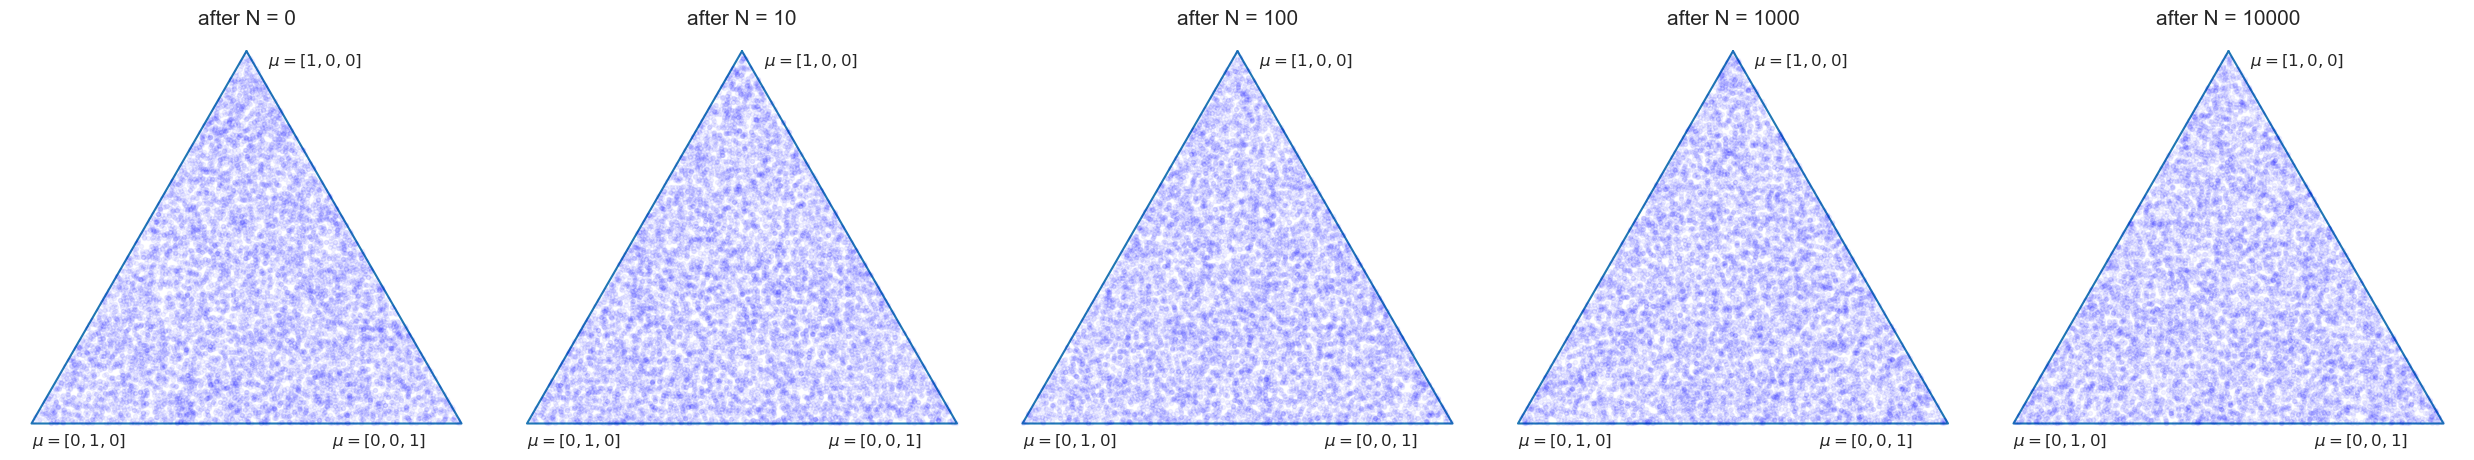

In [ ]:
Npartial_list = [0, 10, 100, 1000, 10000]
L = len(Npartial_list)

fig, axgrid = plt.subplots(
    nrows=1, ncols=L,
    sharex=True, sharey=False,
    figsize=(5 * L, 5))

# Define a grid of mu values at which we'll evaluate the PDF
G = 201
mu_grid_G = np.linspace(0.0001, 0.9999, G)
for aa, Npartial in enumerate(Npartial_list):
    # Compute the parameters of the Beta posterior distribiution, using only first Npartial observations
    alphahat_V = 1.0 * np.ones(3) # <<<<<< FIXME call calc_dirichlet_posterior_parameters

    # Show S samples from the posterior
    xsamp_SV = scipy.stats.dirichlet(alphahat_V).rvs(size=S, random_state=prng)
    
    show_samples_on_V3_triangle(xsamp_SV, ax_handle=axgrid[aa], transparency=0.05)
    axgrid[aa].set_title("after N = %d" % Npartial)
plt.tight_layout();

## Discussion 2c : As N gets larger, what happens to the posterior? How does this compare to what happens to the ML estimator? How does this relate to the "true" mu value that generated the data?

TODO discuss with your group!

## Exercise 2d: Visualizing Posterior given a misinformed prior

Repeat Exercise 2b using the *same* fake data, but act as if your prior was instead 

$$
alpha_V = [1, 9, 99]
$$

(in other words, quite confident in prior belief that the outcome would be in the third category.

Visualize the posterior over mu for the same "fake data" `x_NV`, after seeing each of the Npartial examples as in 2b.

In [ ]:
other_alpha_V = np.asarray([1, 9, 99.0])

In [ ]:
print("Assuming prior is Dir with parameter")
print("alpha_V")
print("-------")
print(other_alpha_V)

Assuming prior is Dir with parameter
alpha_V
-------
[ 1.  9. 99.]


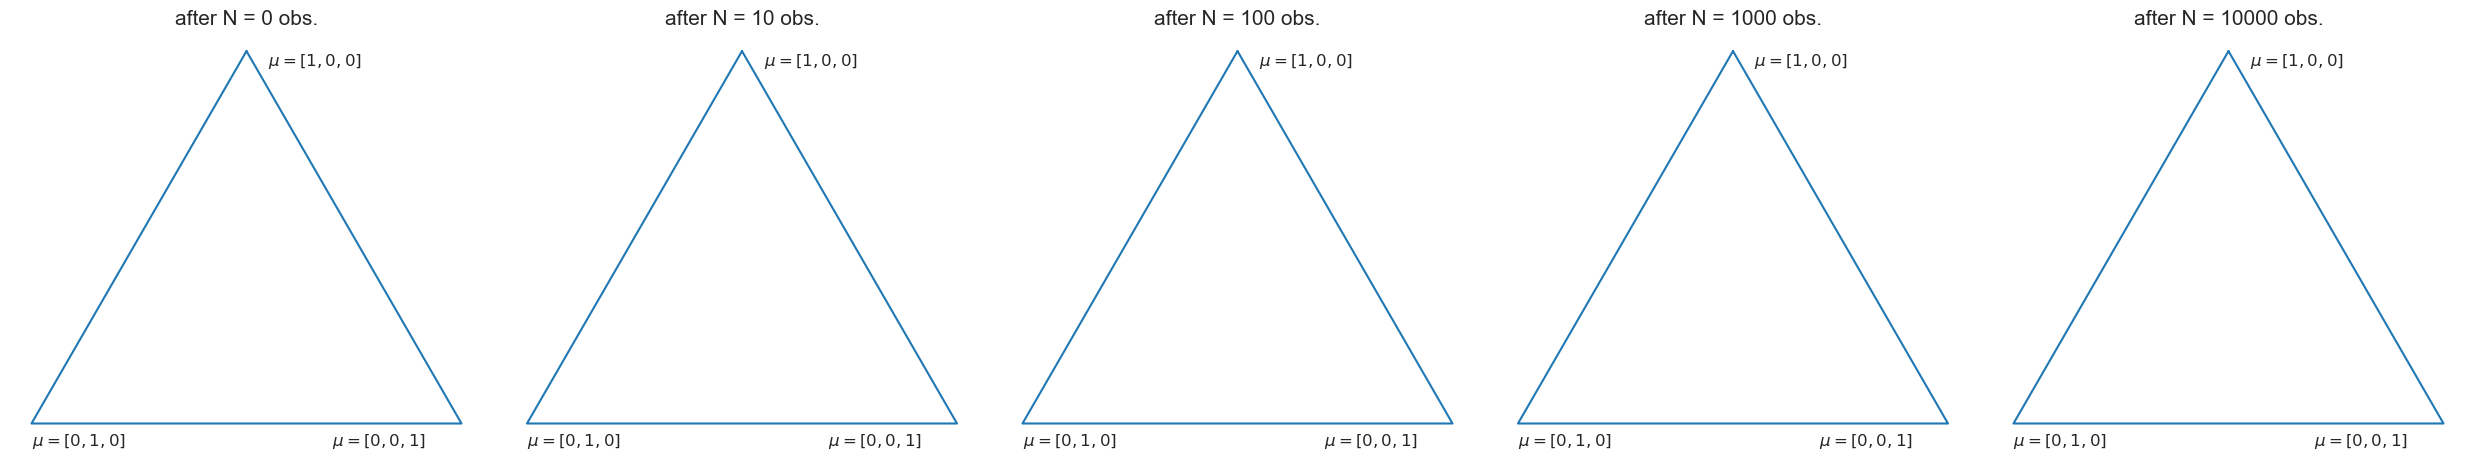

In [ ]:
Npartial_list = [0, 10, 100, 1000, 10000]
L = len(Npartial_list)

fig, axgrid = plt.subplots(
    nrows=1, ncols=L,
    sharex=True, sharey=False,
    figsize=(5 * L, 5))

# Define a grid of mu values at which we'll evaluate the PDF
G = 201
mu_grid_G = np.linspace(0.0001, 0.9999, G)
for aa, Npartial in enumerate(Npartial_list):
    # TODO Compute the parameters of the Beta posterior distribiution, using only first Npartial observations

    # TODO draw S samples from the posterior
    xsamp_SV = np.zeros((0, V)) # <<<<<<<<<<< FIXME
    
    # TODO display the samples on triangle plots
    show_samples_on_V3_triangle(xsamp_SV, ax_handle=axgrid[aa], transparency=0.05)
    axgrid[aa].set_title("after N = %d obs." % Npartial)

plt.tight_layout();

## Discussion 2e: Does having a misinformed prior matter? Discuss how your answer might depend on the amount of available data.

> TODO discuss

## Exercise 2f: Repeat 2d, but for each plot show the location of the *MAP* estimate for $\mu$ on the triangle plot.

> TODO this is a bonus, consider submitting your solution on Piazza